In [5]:
cd /Users/xl/Downloads/借啊/评分卡/1023

/Users/xl/Downloads/借啊/评分卡/1023


In [1]:
import scorecardpy as sc
import pandas as pd
import numpy as np
import datetime
import time
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
%matplotlib inline

/Users/xl/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
def auc_ks(y_hat, y):
    fpr, tpr, thresholds = roc_curve(y, y_hat)
    print('AUC：', auc(fpr, tpr))
    print('KS:', max(abs(tpr - fpr)))
    auc_score = auc(fpr, tpr)
    ks_score = max(abs(tpr - fpr))
    return auc_score, ks_score

In [62]:
# 读取紧急联系人的数据
df = pd.read_csv('df_for_score_1102.csv',index_col=0)

In [9]:
df.columns

Index(['uid', 'income', 'company_address', 'job', 'idcard_2', 'sex',
       'education', 'marriage', 'province', 'city', 'address', 'ip_14',
       'ip_30', 'ip_90', 'device', 'gps_active', 'app_num', 'app_num_lend',
       'app_num_life', 'relation_num_x', 'relation_7_call', 'relation_14_call',
       'relation_30_call', 'relation_30p_call', 'phone_7_call',
       'phone_14_call', 'phone_30_call', 'call_7d', 'call_14d', 'call_30d',
       'call_30pd', 'call_in_7d', 'call_in_14d', 'call_in_30d', 'call_in_30pd',
       'call_out_7d', 'call_out_14d', 'call_out_30d', 'call_out_30pd',
       'call_no_7d', 'call_no_14d', 'call_no_30d', 'call_no_30pd', 'status',
       'age', 'bad', 'apply_hour', 'reg_hour'],
      dtype='object')

In [63]:
df_app = pd.read_excel('zhubiao2_jjq.xlsx')

In [64]:
df_app = df_app[['uid','apply_time','app_num','app_num_lend','app_num_life']]
df_app['apply_time'] = pd.to_datetime(df_app['apply_time'],format = '%d/%m/%Y %H:%M:%S')

In [13]:
df_app.head(2)

,uid,apply_time,app_num,app_num_lend,app_num_life
0,1014193400451731457a,2018-08-12 16:46:15,47,8,2
1,1014313001965621250a,2018-07-13 11:37:25,20,2,1


In [65]:
df_app['mon'] = df_app['apply_time'].dt.month

In [66]:
df_app = df_app[df_app['mon']>8]
df_app["uid"],df_app["aa"]=df_app["uid"].str.split("a").str
df_app = df_app.drop('aa',1)

In [67]:
df_app['uid'] = df_app['uid'].astype('int')

In [175]:
df_df = pd.merge(df_app,df,on = 'uid',how = 'left')

In [176]:
df_df = df_df.drop(['mon','apply_time','app_num_y', 'app_num_lend_y','app_num_life_y'],1)

In [177]:
df_df.columns

Index(['uid', 'app_num_x', 'app_num_lend_x', 'app_num_life_x', 'income',
       'company_address', 'job', 'idcard_2', 'sex', 'education', 'marriage',
       'city', 'address', 'ip_14', 'ip_30', 'ip_90', 'device', 'gps_active',
       'relation_num_x', 'relation_7_call', 'relation_14_call',
       'relation_30_call', 'relation_30p_call', 'phone_7_call',
       'phone_14_call', 'phone_30_call', 'call_7d', 'call_14d', 'call_30d',
       'call_30pd', 'call_in_7d', 'call_in_14d', 'call_in_30d', 'call_in_30pd',
       'call_out_7d', 'call_out_14d', 'call_out_30d', 'call_out_30pd',
       'call_no_7d', 'call_no_14d', 'call_no_30d', 'call_no_30pd', 'age',
       'bad', 'apply_hour', 'reg_hour'],
      dtype='object')

# 处理分类变量

In [178]:
# 处理job
df_df['job'].replace({'Pengajar (Guru , Dosen)':'Guru/Peneliti',
                           'Peneliti':'Guru/Peneliti', 
                           'Dokter':'Dokter /Perawat',
                        'Tenaga Medis (Perawat /Bidan, dsb)':'Dokter /Perawat',
                           'Hukum (Pengacara, Notaris)':'Pengacara',
                      'Desainer':'Arsitek/Desainer',
                           'Arsitek':'Arsitek/Desainer',
                          'Transportasi (Supir)':'Sopir sepeda motor',
                          'Penyelenggara Negara (Selain pejabat /penyelenggara Negara锛':'Penyelenggara Negara (Selain pejabat /penyelenggara Negara）',
                          'Pegawai Pemerintahan / Penyelenggara Negara (Selain pejabat /penyelenggara Negara':'Penyelenggara Negara (Selain pejabat /penyelenggara Negara）',
                          'Perhotelan & Restoran (Koki, Bartender, dsb)':'Catering',
                          'Buruh':'Buruh/Pengamanan',
                          'Pengamanan':'Buruh/Pengamanan',
                          'Lain ü lain':'Lainnya',
                          'Pekerja Informal (Asisten Rumah Tangga, Asongan, dll)':'Lainnya',
                          'Peternak':'Lainnya'},inplace=True)

df_df['job'].replace({'Administrasi Umum':'a',
                           'Marketing':'b', 
                           'Lain – lain':'c',
                        'Wiraswasta':'d',
                           'Buruh/Pengamanan':'e',
                      'Guru/Peneliti':'f',
                           'Catering':'g',
                          'Dokter /Perawat':'h',
                          'Dokter/Perawat':'h',
                          'Sopir truk/bus':'i',
                          'Sopir sepeda motor':'i'},inplace=True)


df_df['job'] = df_df['job'].map(
    lambda s: s if s in ['a','b','c','d','e','f','g','h','i'] else 'else')

In [179]:
df_df['device'].value_counts()

Xiaomi                      1188
OPPO                        1001
samsung                      913
vivo                         408
asus                         167
HUAWEI                        53
Haier                         47
LENOVO                        44
ADVAN                         38
Sony                          32
LGE                           22
Hisense                       15
HMD Global                    11
motorola                      10
BlackBerry                    10
POLYTRON                       8
EVERCOSS                       7
YuLong                         6
Infinix                        5
SHARP                          5
WIKO                           4
LAVA                           3
ZTE                            3
Coolpad                        3
INFINIX MOBILITY LIMITED       3
OnePlus                        3
QUALCOMM                       2
HTC                            2
INFINIX                        2
SPRD                           2
nubia     

In [181]:
# 处理device
df_df['device'].replace({'Xiaomi':'a','OPPO':'b', 
                           'xiaomi':'a',
                        'samsung':'c',
                           'vivo':'d',
                      'asus':'e',
                         'HUAWEI':'f',
                         'Huawei':'f',
                        'Haier':'g',
                        'LENOVO':'h'},inplace=True)
df_df['device'] = df_df['device'].map(
    lambda s: s if s in ['a','b','c','d','e','f','g','h','i'] else 'else')

In [183]:
# 处理city
df_df['city'] = df_df['city'].map(
    lambda s: s if s in ['Kota Jakarta Selatan','Kota Jakarta Timur','Kota Jakarta Barat',
                         'Kota Surabaya','Kota Bekasi ','Kota Depok','Kota Tangerang','Kota Bandung',
                         'Kota Jakarta Utara','Kab. Bogor','Kota Tangerang Selatan'] else 'else')


Binning on 4036 rows and 41 columns in 00:00:29


/Users/xl/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'address': <matplotlib.figure.Figure at 0x1a23910898>,
 'age': <matplotlib.figure.Figure at 0x1a303fc940>,
 'app_num_lend_x': <matplotlib.figure.Figure at 0x1a30406438>,
 'app_num_life_x': <matplotlib.figure.Figure at 0x1a2f3ccb38>,
 'app_num_x': <matplotlib.figure.Figure at 0x1a2fe04fd0>,
 'apply_hour': <matplotlib.figure.Figure at 0x1134ce6a0>,
 'call_14d': <matplotlib.figure.Figure at 0x1a20955240>,
 'call_30d': <matplotlib.figure.Figure at 0x1a2f88e908>,
 'call_30pd': <matplotlib.figure.Figure at 0x1a2fc43860>,
 'call_7d': <matplotlib.figure.Figure at 0x1a2fcd9ef0>,
 'call_in_14d': <matplotlib.figure.Figure at 0x1a2ff63ba8>,
 'call_in_30d': <matplotlib.figure.Figure at 0x1a30004400>,
 'call_in_30pd': <matplotlib.figure.Figure at 0x1a301d3518>,
 'call_in_7d': <matplotlib.figure.Figure at 0x1a3003d588>,
 'call_no_14d': <matplotlib.figure.Figure at 0x1a302d1320>,
 'call_no_30d': <matplotlib.figure.Figure at 0x1a30460be0>,
 'call_no_30pd': <matplotlib.figure.Figure at 0x1a304c36d8>,
 

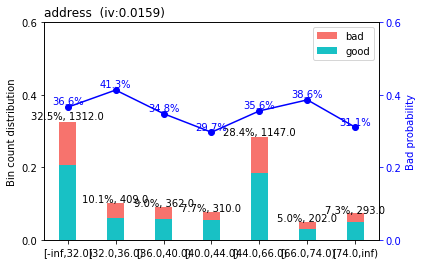

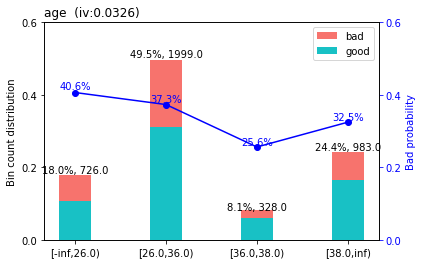

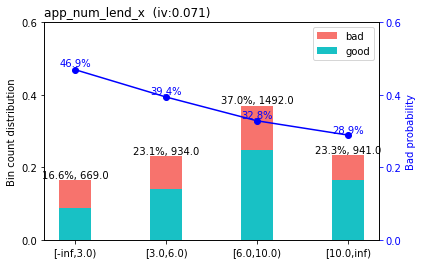

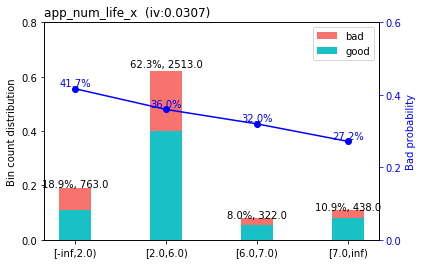

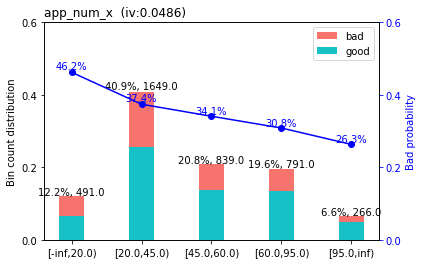

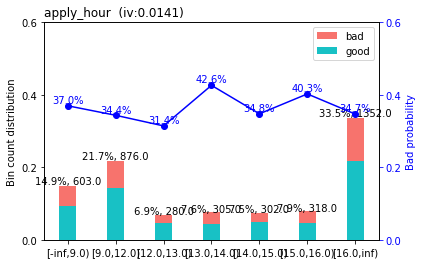

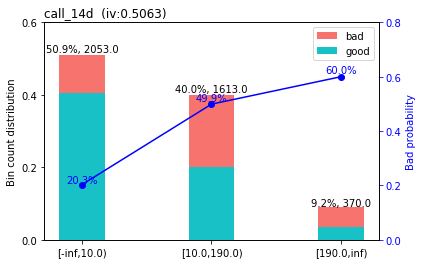

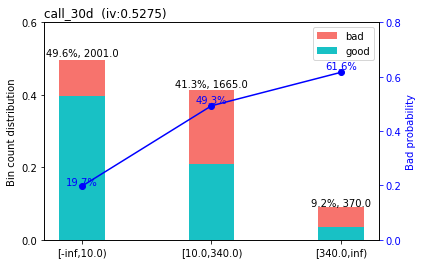

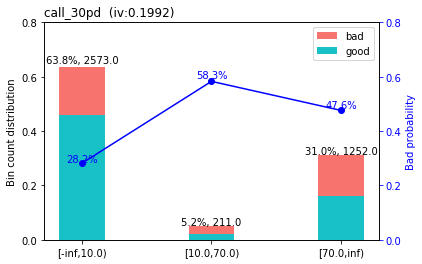

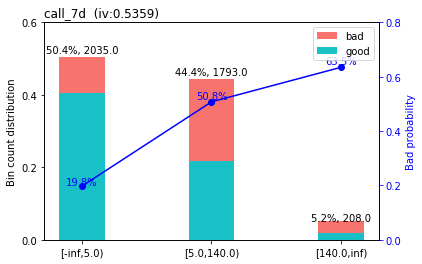

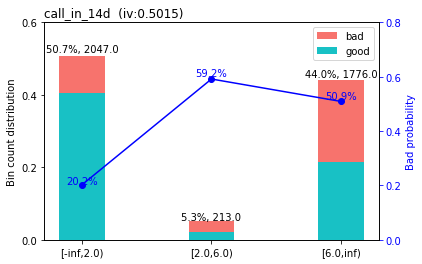

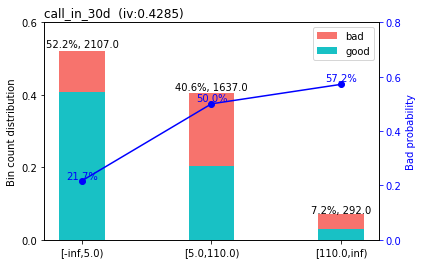

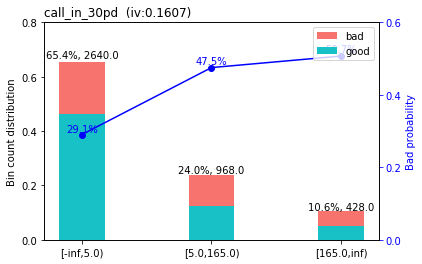

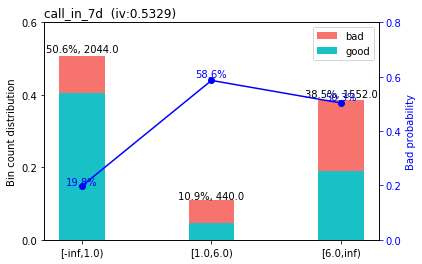

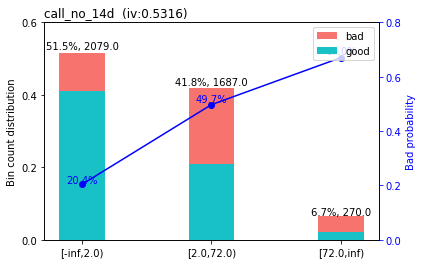

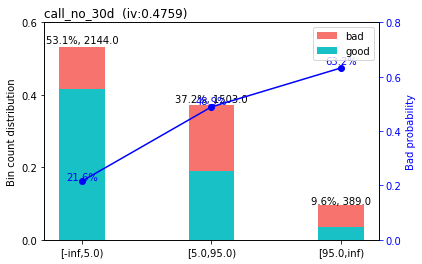

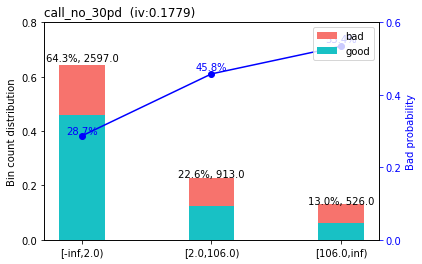

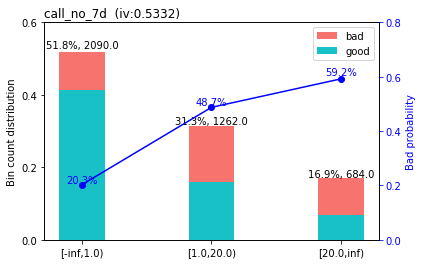

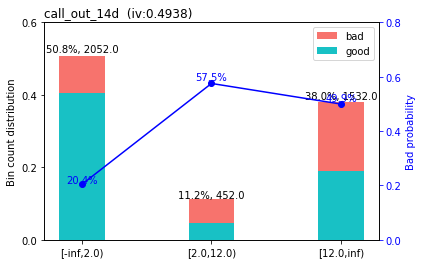

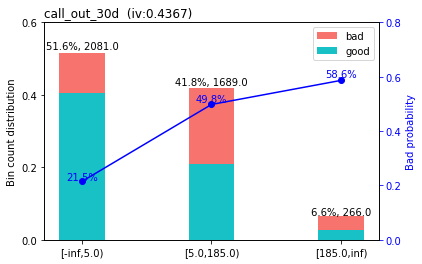

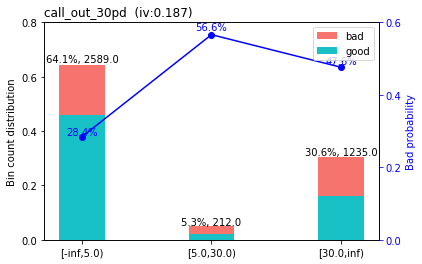

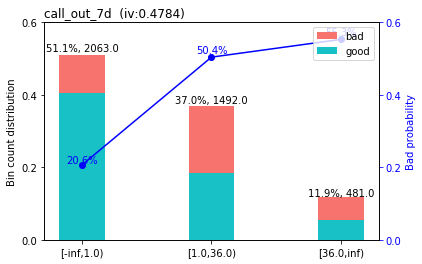

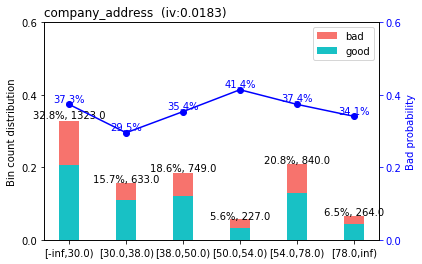

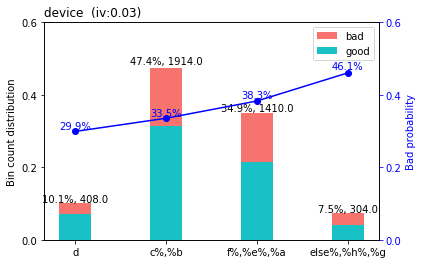

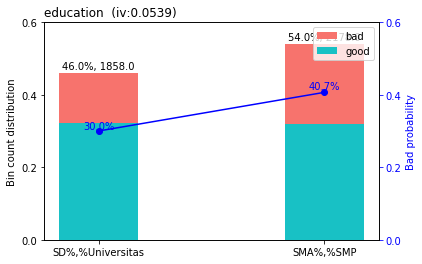

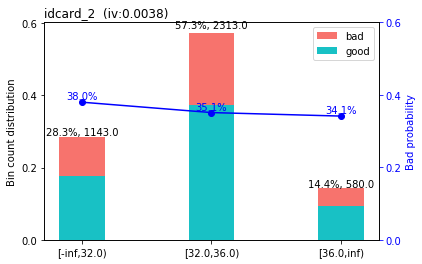

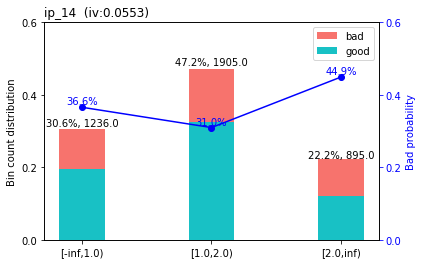

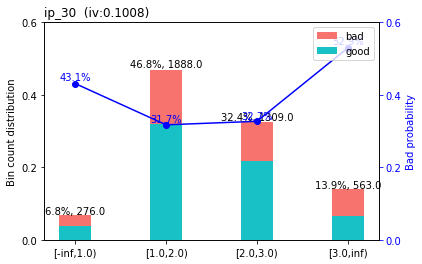

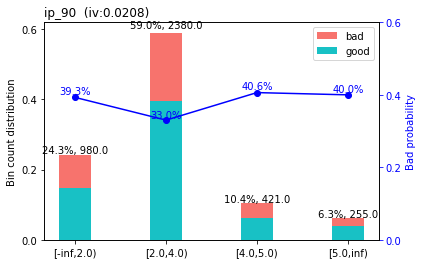

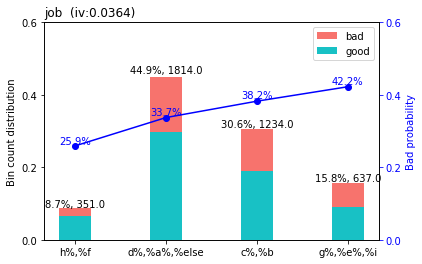

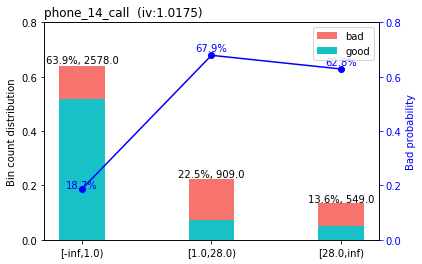

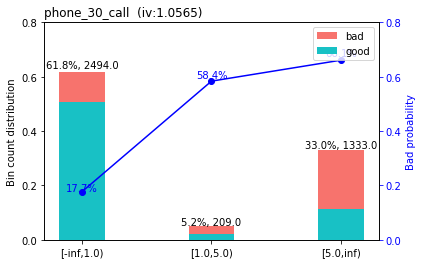

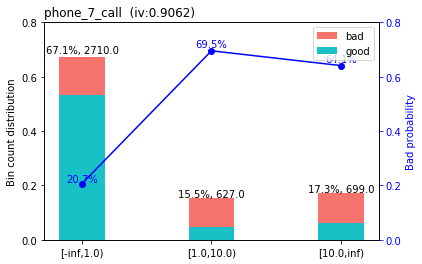

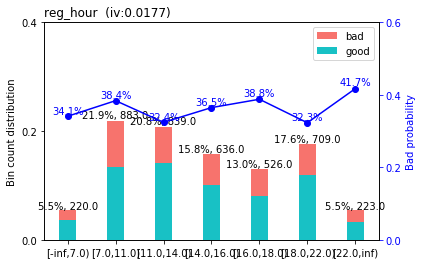

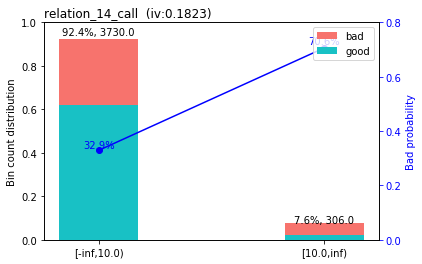

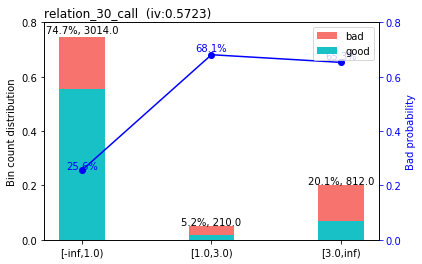

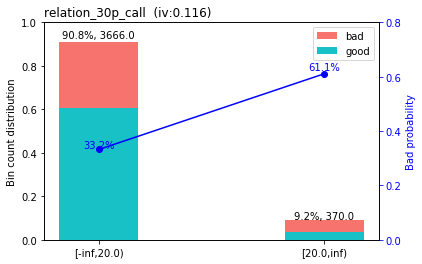

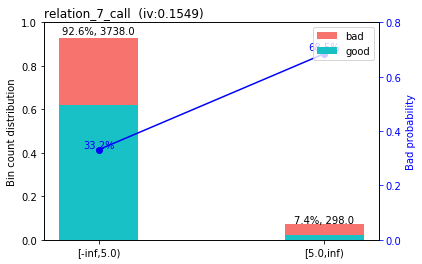

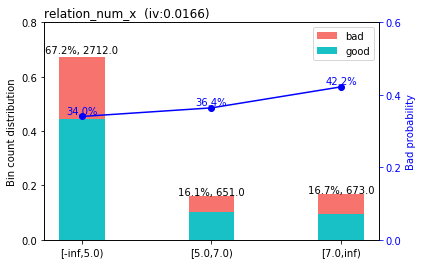

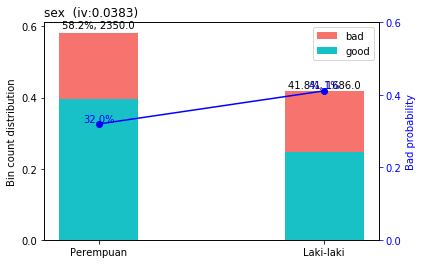

In [185]:
dt = sc.var_filter(df_df, y="bad")
bni = sc.woebin(dt, y="bad")
sc.woebin_plot(bni)

In [186]:
#分测试和训练
train, test = sc.split_df(dt, y = 'bad').values()

train_woe = sc.woebin_ply(train, bni)
test_woe = sc.woebin_ply(test, bni)
y_train = train_woe.loc[:,'bad']
X_train = train_woe.drop(['bad'],1)
y_test = test_woe.loc[:,'bad']
X_test = test_woe.drop(['bad'],1)

lr = LogisticRegression(penalty = 'l1', C = 0.5, solver = 'saga')
lr.fit(X_train, y_train)
ylr_hat = lr.predict_proba(X_test)[:,1]
auc_ks(ylr_hat,y_test)

AUC： 0.8093678942275153
KS: 0.5217648141441608


(0.8093678942275153, 0.5217648141441608)

In [38]:
# card = sc.scorecard(bni, lr, X_train.columns)
# pd.DataFrame.from_dict(card,orient = 'index').to_csv('dic_SS.csv')

In [187]:
df = dt.copy()

In [40]:
# df['in_all_7call'] = df['call_in_7d']/df['call_7d']
# df['out_all_7call'] = df['call_out_7d']/df['call_7d']
# df['no_all_7call'] = df['call_no_7d']/df['call_7d']

# df['in_all_14call'] = df['call_in_14d']/df['call_14d']
# df['no_all_14call'] = df['call_no_14d']/df['call_14d']
# df['out_all_14call'] = df['call_out_14d']/df['call_14d']

# df['in_all_30call'] = df['call_in_30d']/df['call_30d']
# df['no_all_30call'] = df['call_no_30d']/df['call_30d']
# df['out_all_30call'] = df['call_out_30d']/df['call_30d']

# replace_dic = dict(zip(set(df['job_new']),range(-1,len(set(df['job_new'])))))
# df['job_new'].replace(replace_dic,inplace = True)

# replace_dic_pro = dict(zip(set(df['edu_new']),range(-1,len(set(df['edu_new'])))))
# df['edu_new'].replace(replace_dic_pro,inplace = True)

# replace_dic_dev = dict(zip(set(df['device']),range(-1,len(set(df['device'])))))
# df['device'].replace(replace_dic_dev,inplace = True)

# # xgb
# x = df.drop('bad',1)
# y = df['bad']
# x_trainx, x_testx, y_trainx, y_testx = train_test_split(x, y, test_size=0.2,random_state=66)

# clf = xgb.XGBClassifier()
# clf.fit(x_trainx, y_trainx)

# y_hatx = clf.predict_proba(x_testx)[:,1]
# auc_ks(y_hatx,y_testx)

AUC： 0.7696861873963842
KS: 0.4001520244811837


(0.7696861873963842, 0.4001520244811837)

In [41]:
var_xgb =  dict(zip(x_trainx.columns, clf.feature_importances_))
pd.DataFrame.from_dict(var_xgb,orient='index').reset_index().to_csv('x_比例.csv')

# 比例类衍生变量

In [192]:
dt_s = dt.copy()

In [104]:
# dt_s['in_all_7call'] = dt_s['call_in_7d']/dt_s['call_7d']
# dt_s['out_all_7call'] = dt_s['call_out_7d']/dt_s['call_7d']
# dt_s['no_all_7call'] = dt_s['call_no_7d']/dt_s['call_7d']

# dt_s['in_all_14call'] = dt_s['call_in_14d']/dt_s['call_14d']
# dt_s['no_all_14call'] = dt_s['call_no_14d']/dt_s['call_14d']
# dt_s['out_all_14call'] = dt_s['call_out_14d']/dt_s['call_14d']

# dt_s['in_all_30call'] = dt_s['call_in_30d']/dt_s['call_30d']
# dt_s['no_all_30call'] = dt_s['call_no_30d']/dt_s['call_30d']
# dt_s['out_all_30call'] = dt_s['call_out_30d']/dt_s['call_30d']

# dt_s['in_all_30pcall'] = dt_s['call_in_30pd']/dt_s['call_30pd']
# dt_s['no_all_30pcall'] = dt_s['call_no_30pd']/dt_s['call_30pd']
# dt_s['out_all_30pcall'] = dt_s['call_out_30pd']/dt_s['call_30pd']

In [194]:
dt_s['idcard_2'].replace({32:'a',
                           31:'b', 
                           35:'c',
                        36:'d',
                           33:'e',
                      51:'f',
                           34:'g',
                          12:'h'
                         },inplace=True)

In [196]:
dt_s['idcard_2'] = dt_s['idcard_2'].map(
    lambda s: s if s in ['a','b','c','d','e','f','g','h'] else 'else')

In [198]:
dt_s = dt_s[['address','bad','age','app_num_lend_x','apply_hour','company_address','education',
            'idcard_2','ip_30','job','reg_hour','sex','call_no_30d','device']]

Binning on 4036 rows and 13 columns in 00:00:12


{'address': <matplotlib.figure.Figure at 0x1a27635b38>,
 'age': <matplotlib.figure.Figure at 0x1a32bcd390>,
 'app_num_lend_x': <matplotlib.figure.Figure at 0x1a23297128>,
 'apply_hour': <matplotlib.figure.Figure at 0x1a3292abe0>,
 'call_no_30d': <matplotlib.figure.Figure at 0x1a33064630>,
 'company_address': <matplotlib.figure.Figure at 0x1a30bfa828>,
 'device': <matplotlib.figure.Figure at 0x1a2ef6db70>,
 'education': <matplotlib.figure.Figure at 0x1a2e0104e0>,
 'ip_30': <matplotlib.figure.Figure at 0x1a2df70e80>,
 'job': <matplotlib.figure.Figure at 0x1a2ee82898>,
 'reg_hour': <matplotlib.figure.Figure at 0x1a2eefaf60>,
 'sex': <matplotlib.figure.Figure at 0x1a32da85c0>}

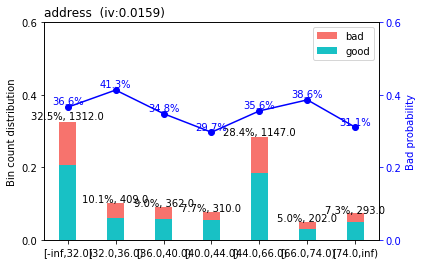

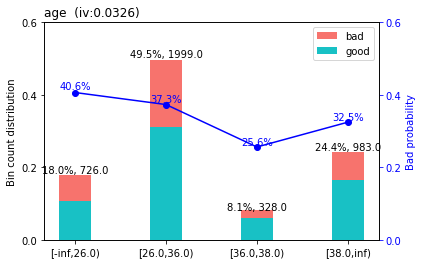

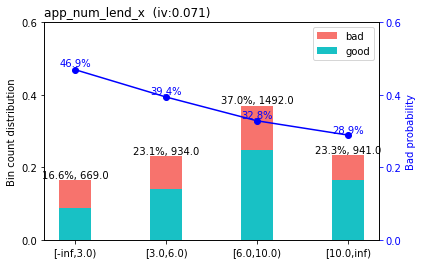

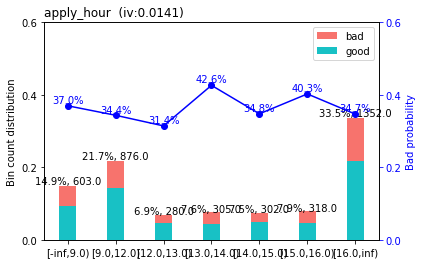

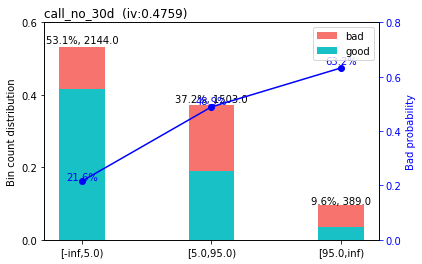

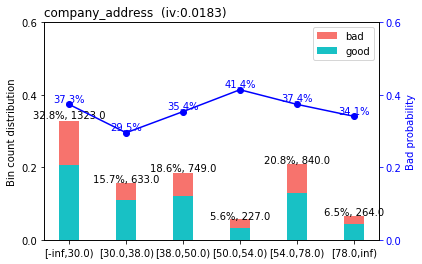

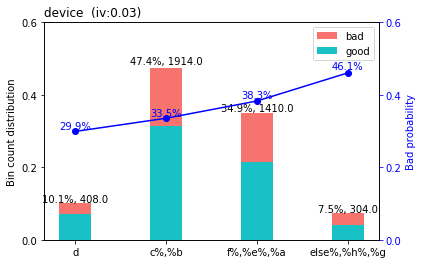

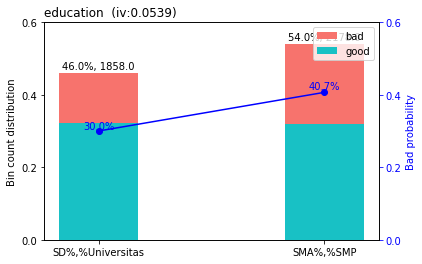

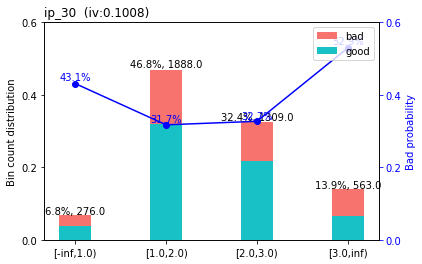

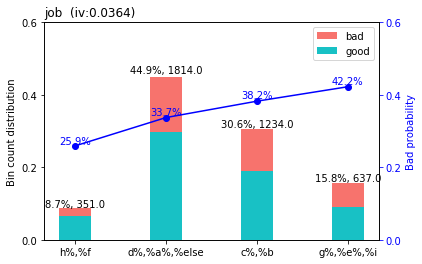

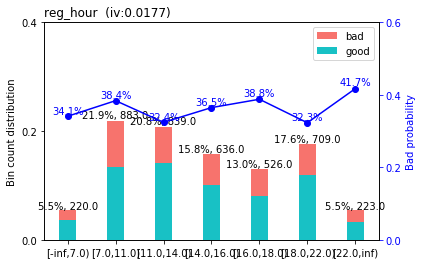

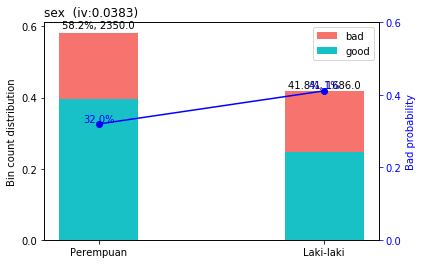

In [199]:
dt_s1 = sc.var_filter(dt_s, y="bad")
bins1 = sc.woebin(dt_s1, y="bad")
sc.woebin_plot(bins1)

In [201]:
#分测试和训练
train1, test1 = sc.split_df(dt_s1, y = 'bad').values()

train_woe1 = sc.woebin_ply(train1, bins1)
test_woe1 = sc.woebin_ply(test1, bins1)

y_train1 = train_woe1.loc[:,'bad']
X_train1 = train_woe1.drop(['bad'],1)
y_test1 = test_woe1.loc[:,'bad']
X_test1 = test_woe1.drop(['bad'],1)

lr1 = LogisticRegression(penalty = 'l2', C = 0.2, solver = 'saga')
lr1.fit(X_train1, y_train1)
ylr_hat1 = lr1.predict_proba(X_test1)[:,1]
auc_ks(ylr_hat1,y_test1)

AUC： 0.7635377025237923
KS: 0.4127181082541247


(0.7635377025237923, 0.4127181082541247)

In [52]:
# # predicted proability
# train_pred = lr1.predict_proba(X_train1)[:,1]
# test_pred = lr1.predict_proba(X_test1)[:,1]

# # performance ks & roc ------
# train_perf = sc.perf_eva(y_train1, train_pred, title = "train")
# # test_perf = sc.perf_eva(y_test1, test_pred, title = "test")

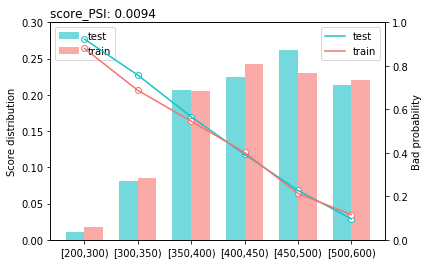

{'pic': {'score': <matplotlib.figure.Figure at 0x1a3093ba58>},
 'psi':   variable       PSI
 0    score  0.009375}

In [202]:
cardS = sc.scorecard(bins1, lr1, X_test1.columns)

# credit score
train_score = sc.scorecard_ply(train1, cardS, print_step=0)
test_score = sc.scorecard_ply(test1, cardS, print_step=0)

# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)
[200,300,350,,,,,500,600]

In [88]:
from sklearn.grid_search import GridSearchCV

/Users/xl/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [204]:
woe = sc.woebin_ply(dt_s1, bins1)

Y = woe.loc[:,'bad']
X = woe.drop(['bad'],1)

param_grid = {'C': np.arange(0.1,4.9,0.1),'penalty': [ 'l1','l2']}
clf_grid = GridSearchCV(
    LogisticRegression(),param_grid,scoring ='roc_auc',cv = 10)
clf_grid.fit(X, Y)

print("Best parameters: {}".format(clf_grid.best_params_))
print("Best cross-validation score: {:.5f}".format(clf_grid.best_score_))

Best parameters: {'C': 1.8000000000000003, 'penalty': 'l2'}
Best cross-validation score: 0.75564


In [112]:
# results = pd.DataFrame(clf_grid.grid_scores_) 
# results

In [255]:
# xgb再来
# x = dt_s1.drop('bad',1)
# y = dt_s1['bad']
# x_trainx, x_testx, y_trainx, y_testx = train_test_split(x, y, test_size=0.2,random_state=66)

# clf = xgb.XGBClassifier()
# clf.fit(x_trainx, y_trainx)

# y_hatx = clf.predict_proba(x_testx)[:,1]
# auc_ks(y_hatx,y_testx)

In [56]:
#找两个模型的系数进行比较
var_lr1 =  dict(zip(X_train1.columns, np.ravel(lr1.coef_)))
pd.DataFrame.from_dict(var_lr1,orient='index').reset_index().to_csv('lr1_coef_coef.csv')

# var_xgb =  dict(zip(x_trainx.columns, clf.feature_importances_))
# pd.DataFrame.from_dict(var_xgb,orient='index').reset_index().to_csv('xgb_feature_imp.csv')

In [102]:
dt_s1.columns

Index(['education', 'company_address', 'idcard_2', 'job', 'apply_hour',
       'reg_hour', 'app_num_lend_x', 'ip_30', 'sex', 'address', 'age', 'bad'],
      dtype='object')

# 部署完整训练

In [212]:
dt_S = dt_s1[['education', 'call_no_30d', 'company_address', 'device', 'job',
       'apply_hour', 'app_num_lend_x','ip_30','sex', 'reg_hour',
       'age', 'bad']]

In [213]:
dt_S.columns

Index(['education', 'call_no_30d', 'company_address', 'device', 'job',
       'apply_hour', 'app_num_lend_x', 'ip_30', 'sex', 'reg_hour', 'age',
       'bad'],
      dtype='object')

In [214]:
dt_S.corr()

,call_no_30d,company_address,apply_hour,app_num_lend_x,ip_30,reg_hour,age,bad
call_no_30d,1.000000,0.001379,0.032050,0.054807,-0.088891,-0.008340,-0.039845,0.227944
company_address,0.001379,1.000000,-0.023469,-0.004034,0.020455,-0.021458,-0.017530,0.006001
apply_hour,0.032050,-0.023469,1.000000,-0.000170,-0.014546,0.130535,-0.026460,-0.006141
app_num_lend_x,0.054807,-0.004034,-0.000170,1.000000,0.003267,0.021071,-0.017654,-0.103974
ip_30,-0.088891,0.020455,-0.014546,0.003267,1.000000,0.024723,0.022482,0.090230
reg_hour,-0.008340,-0.021458,0.130535,0.021071,0.024723,1.000000,-0.002123,-0.004788
age,-0.039845,-0.017530,-0.026460,-0.017654,0.022482,-0.002123,1.000000,-0.057601
bad,0.227944,0.006001,-0.006141,-0.103974,0.090230,-0.004788,-0.057601,1.000000


In [233]:
breaks_adj = {'call_no_30d':[20,90,'Inf%,%missing']}

Binning on 4036 rows and 12 columns in 00:00:11


{'age': <matplotlib.figure.Figure at 0x1a353f19e8>,
 'app_num_lend_x': <matplotlib.figure.Figure at 0x1a33769780>,
 'apply_hour': <matplotlib.figure.Figure at 0x115d1dcc0>,
 'call_no_30d': <matplotlib.figure.Figure at 0x1118621d0>,
 'company_address': <matplotlib.figure.Figure at 0x1a35f9ba20>,
 'device': <matplotlib.figure.Figure at 0x1a232e4080>,
 'education': <matplotlib.figure.Figure at 0x112df6240>,
 'ip_30': <matplotlib.figure.Figure at 0x112e7b828>,
 'job': <matplotlib.figure.Figure at 0x1a2d2e8dd8>,
 'reg_hour': <matplotlib.figure.Figure at 0x1a2edb4898>,
 'sex': <matplotlib.figure.Figure at 0x1a32f76208>}

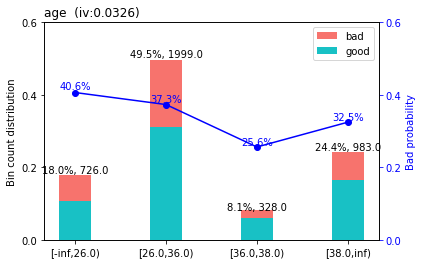

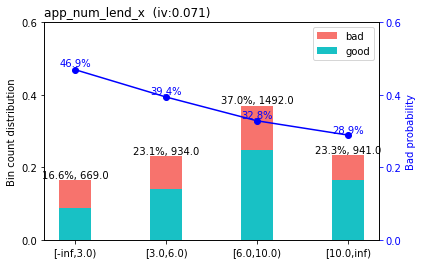

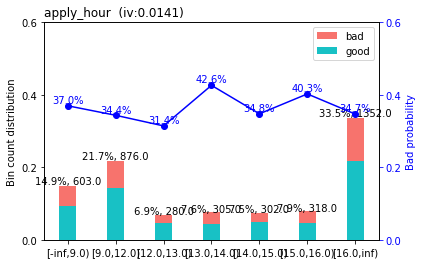

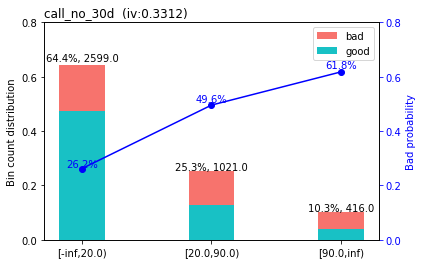

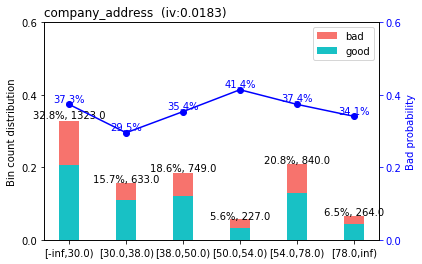

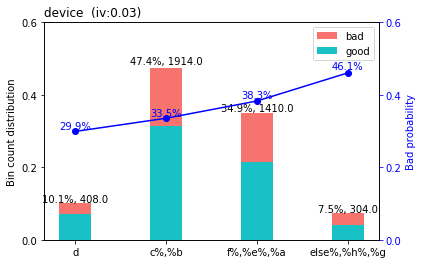

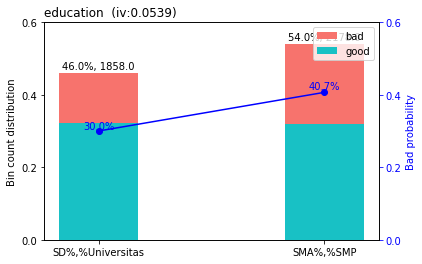

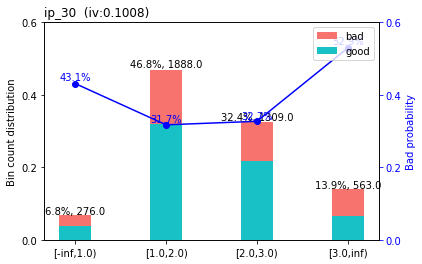

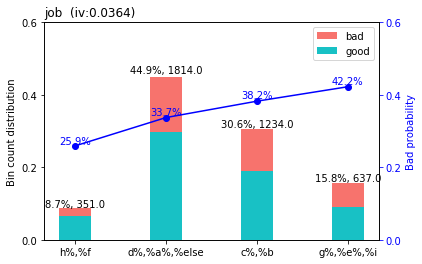

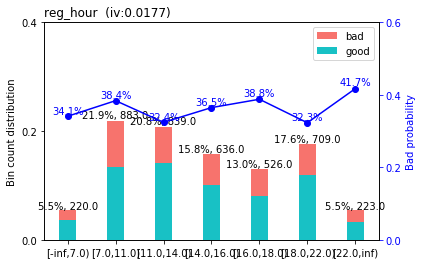

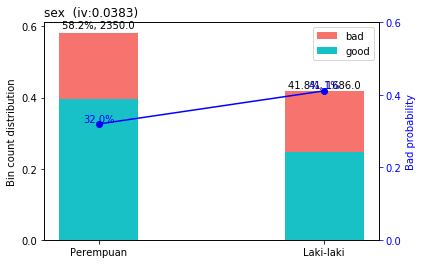

In [234]:
dt_S = sc.var_filter(dt_S, y="bad")
binS = sc.woebin(dt_S,breaks_list=breaks_adj ,y="bad")
sc.woebin_plot(binS)

In [220]:
#不进行调整
# dt_S = sc.var_filter(dt_S, y="bad")
# binS = sc.woebin(dt_S, y="bad")
# sc.woebin_plot(binS)

In [235]:
#分测试和训练
trainS, testS = sc.split_df(dt_S, y = 'bad').values()

train_woeS = sc.woebin_ply(trainS, binS)
test_woeS = sc.woebin_ply(testS, binS)
y_trainS = train_woeS.loc[:,'bad']
X_trainS = train_woeS.drop(['bad'],1)
y_testS = test_woeS.loc[:,'bad']
X_testS = test_woeS.drop(['bad'],1)

lrS = LogisticRegression(penalty = 'l2', C = 0.2, solver = 'saga')
lrS.fit(X_trainS, y_trainS)
ylr_hatS = lrS.predict_proba(X_testS)[:,1]
auc_ks(ylr_hatS,y_testS)

AUC： 0.7484148375950652
KS: 0.3729139084642923


(0.7484148375950652, 0.3729139084642923)

In [236]:
woe = sc.woebin_ply(dt_S, binS)

Y = woe.loc[:,'bad']
X = woe.drop(['bad'],1)

param_grid = {'C': np.arange(0.1,4.9,0.1),'penalty': [ 'l1','l2']}
clf_grid = GridSearchCV(
    LogisticRegression(),param_grid,scoring ='roc_auc',cv = 10)
clf_grid.fit(X, Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [237]:
print("Best parameters: {}".format(clf_grid.best_params_))
print("Best cross-validation score: {:.5f}".format(clf_grid.best_score_))

Best parameters: {'C': 0.6, 'penalty': 'l2'}
Best cross-validation score: 0.73307


In [238]:
woeS = sc.woebin_ply(dt_S, binS)

Y = woeS.loc[:,'bad']
X = woeS.drop(['bad'],1)

lrS = LogisticRegression(penalty = 'l2', C = 0.6, solver = 'saga')
lrS.fit(X, Y)

LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [239]:
lrS.coef_

array([[0.75772768, 1.11046603, 0.90042392, 0.79195462, 0.4934143 ,
        0.90983825, 1.12685032, 1.17459097, 0.68362389, 0.89568274,
        0.93859988]])

In [240]:
cardr = sc.scorecard(binS, lrS, X_trainS.columns)
pd.DataFrame.from_dict(cardr,orient = 'index').to_csv('1104_Score_nocall.csv')

In [241]:
# credit score
Score = sc.scorecard_ply(dt_S, cardr, print_step=1)
#test_score = sc.scorecard_ply(test, card, print_step=0)
#score排序
#pd.DataFrame.from_dict(dict(zip(Score,Y)),orient = 'index').reset_index().to_csv('确定通过率阈值.csv')
Score['label'] = Y
Score.to_csv('1104_阈值_nocall.csv')

# 去除共线性后少变量入模

In [79]:
# dt_S = dt_s1[['age','sex','company_address','address','ip_30','relation_num_x',
#               'edu_new','device','reg_hour','app_num_lend','apply_hour',
#              'job_new','bad']]
# dt_S = sc.var_filter(dt_S, y="bad")
# dt_S.corr()

,ip_30,relation_num_x,company_address,app_num_lend,sex,age,apply_hour,address,reg_hour,bad
ip_30,1.000000,0.373492,0.020455,0.003267,0.001218,0.022482,-0.014546,0.029767,0.024723,0.090230
relation_num_x,0.373492,1.000000,-0.008265,0.079545,0.048931,0.109328,-0.021252,0.014912,-0.025161,0.047786
company_address,0.020455,-0.008265,1.000000,-0.004034,-0.139309,-0.017530,-0.023469,0.446480,-0.021458,0.006001
app_num_lend,0.003267,0.079545,-0.004034,1.000000,0.091251,-0.017654,-0.000170,-0.012641,0.021071,-0.103974
sex,0.001218,0.048931,-0.139309,0.091251,1.000000,-0.145134,0.047650,-0.108140,0.032574,-0.094098
age,0.022482,0.109328,-0.017530,-0.017654,-0.145134,1.000000,-0.026460,0.041265,-0.002123,-0.057601
apply_hour,-0.014546,-0.021252,-0.023469,-0.000170,0.047650,-0.026460,1.000000,-0.028763,0.130535,-0.006141
address,0.029767,0.014912,0.446480,-0.012641,-0.108140,0.041265,-0.028763,1.000000,0.001885,-0.018284
reg_hour,0.024723,-0.025161,-0.021458,0.021071,0.032574,-0.002123,0.130535,0.001885,1.000000,-0.004788
bad,0.090230,0.047786,0.006001,-0.103974,-0.094098,-0.057601,-0.006141,-0.018284,-0.004788,1.000000


{'address': <matplotlib.figure.Figure at 0x1a131906d8>,
 'age': <matplotlib.figure.Figure at 0x1a2751ef98>,
 'app_num_lend': <matplotlib.figure.Figure at 0x1a27e82828>,
 'apply_hour': <matplotlib.figure.Figure at 0x1a27ed1588>,
 'company_address': <matplotlib.figure.Figure at 0x1a27b0cac8>,
 'device': <matplotlib.figure.Figure at 0x1a2806d978>,
 'edu_new': <matplotlib.figure.Figure at 0x1a2811a4e0>,
 'ip_30': <matplotlib.figure.Figure at 0x1a281a2668>,
 'job_new': <matplotlib.figure.Figure at 0x1a28234f28>,
 'reg_hour': <matplotlib.figure.Figure at 0x1a282f1128>,
 'relation_num_x': <matplotlib.figure.Figure at 0x1a2839d5f8>,
 'sex': <matplotlib.figure.Figure at 0x1a28434160>}

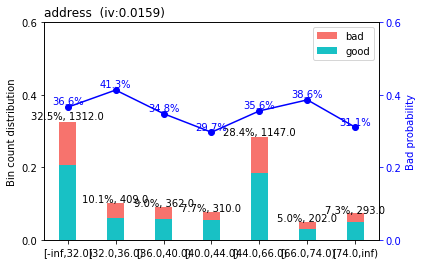

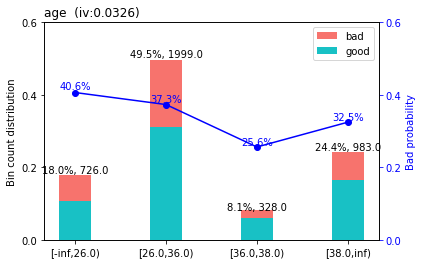

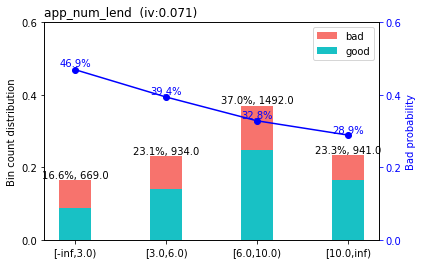

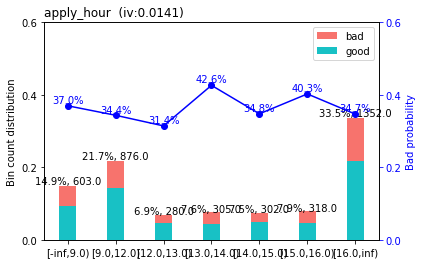

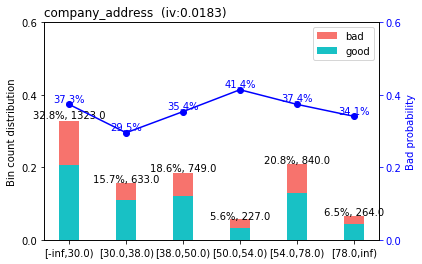

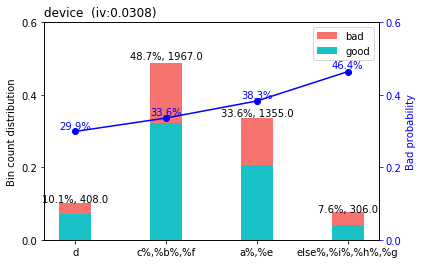

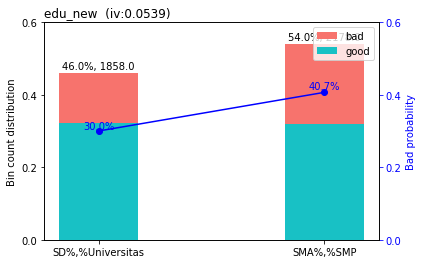

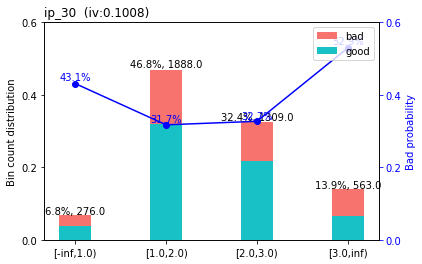

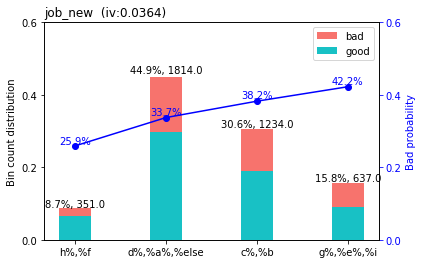

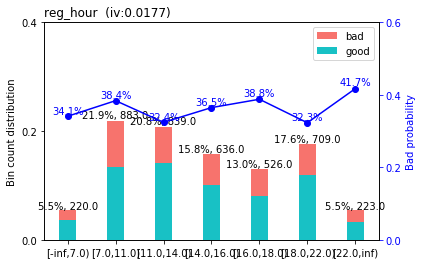

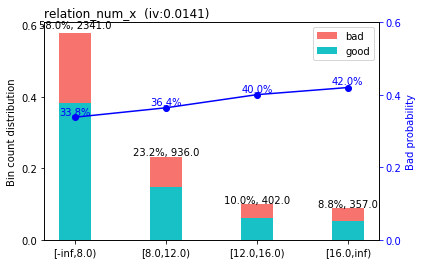

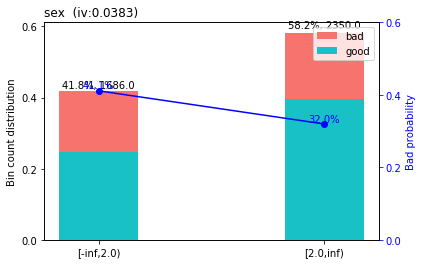

In [80]:
# binS = sc.woebin(dt_S, y="bad")
# sc.woebin_plot(binS)

In [222]:
#分测试和训练
# trainS, testS = sc.split_df(dt_S, y = 'bad').values()

# train_woeS = sc.woebin_ply(trainS, binS)
# test_woeS = sc.woebin_ply(testS, binS)
# y_trainS = train_woeS.loc[:,'bad']
# X_trainS = train_woeS.drop(['bad'],1)
# y_testS = test_woeS.loc[:,'bad']
# X_testS = test_woeS.drop(['bad'],1)

# lrS = LogisticRegression(penalty = 'l2', C = 1.1, solver = 'saga')
# lrS.fit(X_trainS, y_trainS)
# ylr_hatS = lrS.predict_proba(X_testS)[:,1]
# auc_ks(ylr_hatS,y_testS)

AUC： 0.7442485914614959
KS: 0.36988310169380834


(0.7442485914614959, 0.36988310169380834)

In [223]:
#全部数据调参
# woe = sc.woebin_ply(dt_S, binS)

# Y = woe.loc[:,'bad']
# X = woe.drop(['bad'],1)

# param_grid = {'C': np.arange(0.1,4.9,0.1),'penalty': [ 'l2','l1']}
# clf_grid = GridSearchCV(
#     LogisticRegression(),param_grid,scoring ='roc_auc',cv = 10)
# clf_grid.fit(X, Y)

# print("Best parameters: {}".format(clf_grid.best_params_))
# print("Best cross-validation score: {:.5f}".format(clf_grid.best_score_))

Best parameters: {'C': 0.5, 'penalty': 'l2'}
Best cross-validation score: 0.72801


In [224]:
# woeS = sc.woebin_ply(dt_S, binS)

# Y = woeS.loc[:,'bad']
# X = woeS.drop(['bad'],1)

# lrS = LogisticRegression(penalty = 'l2', C = 0.5, solver = 'saga')
# lrS.fit(X, Y)

# lrS.coef_

array([[0.77712094, 1.11353053, 0.89971658, 0.7917343 , 0.48910692,
        0.86561541, 1.10228498, 1.15441012, 0.71550306, 0.87422334,
        0.89841765]])

In [73]:
# cardr = sc.scorecard(binS, lrS, X_trainS.columns)
# pd.DataFrame.from_dict(cardr,orient = 'index').to_csv('Score_9VAR.csv')

In [74]:
# credit score
# Score = sc.scorecard_ply(dt_S, cardr, print_step=1)
# #test_score = sc.scorecard_ply(test, card, print_step=0)
# #score排序
# #pd.DataFrame.from_dict(dict(zip(Score,Y)),orient = 'index').reset_index().to_csv('确定通过率阈值.csv')
# Score['label'] = Y
# Score.to_csv('9变量__确定通过率阈值.csv')

# 用首逾率作为目标

In [453]:
# df_bad_o = pd.read_csv('df_all_1028.csv',index_col=0)
# df_bad = df_bad_o[['uid','over_due_day']]

# df_0d = pd.merge(df_calss, df_bad, on = 'uid', how = 'left')

# df_0d.loc[df_0d['over_due_day']>0,'bad'] = 1
# df_0d.loc[df_0d['over_due_day'] == 0,'bad'] = 0

In [454]:
# df_0d = pd.merge(df_df, df_0d, on = 'uid', how = 'left')

In [455]:
# df_0d.columns

Index(['uid', 'app_num', 'app_num_lend', 'app_num_life', 'income',
       'company_address', 'job', 'idcard_2', 'idcard_4', 'sex', 'education',
       'marriage', 'province', 'city', 'address', 'N4', 'N7', 'a1', 'a2', 'a3',
       'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'ip_14', 'ip_30', 'ip_90',
       'device', 'gps_active', 'relation_num_x', 'relation_7_call',
       'relation_num_y', 'mes_30pd', 'relation_num', 'call_7d', 'call_14d',
       'call_30d', 'call_30pd', 'call_in_7d', 'call_in_14d', 'call_in_30d',
       'call_in_30pd', 'call_out_7d', 'call_out_14d', 'call_out_30d',
       'call_out_30pd', 'call_no_7d', 'call_no_14d', 'call_no_30d',
       'call_no_30pd', 'age', 'bad_x', 'apply_hour', 'reg_hour', 'city_new',
       'job_new', 'edu_new', 'marriage_new', 'inco_new', 'over_due_day',
       'bad_y'],
      dtype='object')

In [456]:
# # 处理job
# df_0d['job_new'].replace({'Pengajar (Guru , Dosen)':'Guru/Peneliti',
#                            'Peneliti':'Guru/Peneliti', 
#                            'Dokter':'Dokter /Perawat',
#                         'Tenaga Medis (Perawat /Bidan, dsb)':'Dokter /Perawat',
#                            'Hukum (Pengacara, Notaris)':'Pengacara',
#                       'Desainer':'Arsitek/Desainer',
#                            'Arsitek':'Arsitek/Desainer',
#                           'Transportasi (Supir)':'Sopir sepeda motor',
#                           'Penyelenggara Negara (Selain pejabat /penyelenggara Negara锛':'Penyelenggara Negara (Selain pejabat /penyelenggara Negara）',
#                           'Pegawai Pemerintahan / Penyelenggara Negara (Selain pejabat /penyelenggara Negara':'Penyelenggara Negara (Selain pejabat /penyelenggara Negara）',
#                           'Perhotelan & Restoran (Koki, Bartender, dsb)':'Catering',
#                           'Buruh':'Buruh/Pengamanan',
#                           'Pengamanan':'Buruh/Pengamanan',
#                           'Lain ü lain':'Lainnya',
#                           'Pekerja Informal (Asisten Rumah Tangga, Asongan, dll)':'Lainnya',
#                           'Peternak':'Lainnya'},inplace=True)

# df_0d['job_new'].replace({'Administrasi Umum':'a',
#                            'Marketing':'b', 
#                            'Lain – lain':'c',
#                         'Wiraswasta':'d',
#                            'Buruh/Pengamanan':'e',
#                       'Guru/Peneliti':'f',
#                            'Catering':'g',
#                           'Dokter /Perawat':'h',
#                           'Dokter/Perawat':'h',
#                           'Sopir truk/bus':'i',
#                           'Sopir sepeda motor':'i'},inplace=True)


# df_0d['job_new'] = df_0d['job_new'].map(
#     lambda s: s if s in ['a','b','c','d','e','f','g','h','i'] else 'else')

# df_0d['device'].replace({49:'a',
#                            8:'b', 
#                            44:'c',
#                         39:'d',
#                            53:'e',
#                       11:'f',
#                            27:'g',
#                           3:'h',
#                          12:'i'},inplace=True)


# df_0d['device'] = df_0d['device'].map(
#     lambda s: s if s in ['a','b','c','d','e','f','g','h','i'] else 'else')

In [457]:
# # 处理inco_new
# df_0d['inco_new'].replace({'Rp3.000.001-5.000.000':'a',
#                            'Rp5.000.001-10.000.000':'b', 
#                            'Rp1.500.001-3.000.000':'c',
#                         'Rp10.000.001-20.000.000':'d',
#                            'RP20.000.001-30.000.000':'e',
#                           'RP30.000.000+':'f',
#                           '0-Rp1.500.000':'f'},inplace=True)

# # 处理marriage_new
# df_0d['marriage_new'].replace({'Sudah Menikah dan Sudah Punya Anak':'a',
#                            'Sudah Menikah Belum Punya Anak':'b'},inplace=True)

# # 处理edu_new
# df_0d['edu_new'].replace({'Sekolah Menengah Atas (SMA)':'SMA',
#                            'Sekolah Menengah Pertama (SMP)':'SMP',
#                            'Sekolah Dasar (SD)':'SD'},inplace=True)

# # 处理city_new
# df_0d['city_new'] = df_0d['city_new'].map(
#     lambda s: s if s in ['Kota Jakarta Selatan','Kota Jakarta Timur',
#                                                              'Kota Jakarta Barat','Kota Surabaya','Kota Bekasi ',
#                                                              'Kota Depok','Kota Tangerang','Kota Bandung',
#                                                              'Kota Jakarta Utara','Kab. Bogor','Kota Tangerang Selatan'] else 'else')


In [468]:
# df_0d = df_0d.drop('bad_x',1)
# df_0d = df_0d.drop(['over_due_day','uid'],1)
# df_0d.columns

Index(['app_num', 'app_num_lend', 'app_num_life', 'income', 'company_address',
       'job', 'idcard_2', 'idcard_4', 'sex', 'education', 'marriage',
       'province', 'city', 'address', 'N4', 'N7', 'a1', 'a2', 'a3', 'a4', 'a5',
       'a6', 'a7', 'a8', 'a9', 'a10', 'ip_14', 'ip_30', 'ip_90', 'device',
       'gps_active', 'relation_num_x', 'relation_7_call', 'relation_num_y',
       'mes_30pd', 'relation_num', 'call_7d', 'call_14d', 'call_30d',
       'call_30pd', 'call_in_7d', 'call_in_14d', 'call_in_30d', 'call_in_30pd',
       'call_out_7d', 'call_out_14d', 'call_out_30d', 'call_out_30pd',
       'call_no_7d', 'call_no_14d', 'call_no_30d', 'call_no_30pd', 'age',
       'apply_hour', 'reg_hour', 'city_new', 'job_new', 'edu_new',
       'marriage_new', 'inco_new', 'bad_y'],
      dtype='object')

Variable filtering on 4036 rows and 61 columns in 00:00:14 
16 variables are removed
Binning on 4036 rows and 45 columns in 00:01:26


/Users/xl/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'a1': <matplotlib.figure.Figure at 0x1a4f7ca358>,
 'a10': <matplotlib.figure.Figure at 0x1a517f15c0>,
 'a4': <matplotlib.figure.Figure at 0x1a4cfe5a20>,
 'a5': <matplotlib.figure.Figure at 0x1a49a71828>,
 'a6': <matplotlib.figure.Figure at 0x1a549802b0>,
 'a7': <matplotlib.figure.Figure at 0x1a5a7b1b00>,
 'a8': <matplotlib.figure.Figure at 0x1a56fb5080>,
 'a9': <matplotlib.figure.Figure at 0x1a58e19d68>,
 'address': <matplotlib.figure.Figure at 0x1a5b9a3a90>,
 'age': <matplotlib.figure.Figure at 0x1a56bc9048>,
 'app_num': <matplotlib.figure.Figure at 0x1a5be5fda0>,
 'app_num_lend': <matplotlib.figure.Figure at 0x1a5b90a4a8>,
 'app_num_life': <matplotlib.figure.Figure at 0x1a5d2960b8>,
 'apply_hour': <matplotlib.figure.Figure at 0x1a4dad9b38>,
 'call_14d': <matplotlib.figure.Figure at 0x1a5b48ac88>,
 'call_30d': <matplotlib.figure.Figure at 0x1a5b8234e0>,
 'call_30pd': <matplotlib.figure.Figure at 0x1a5b4f6278>,
 'call_7d': <matplotlib.figure.Figure at 0x1a4da5cf98>,
 'call_in_14d': <m

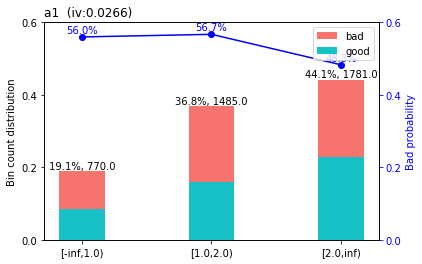

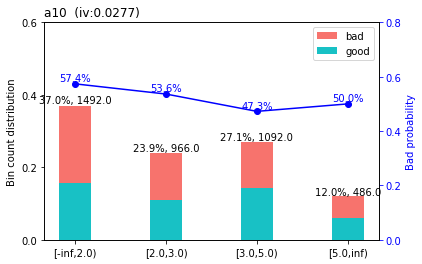

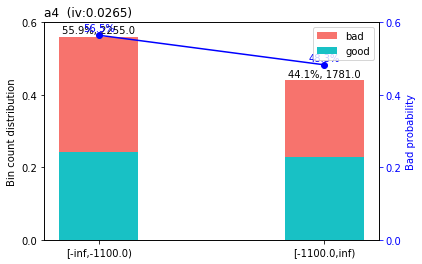

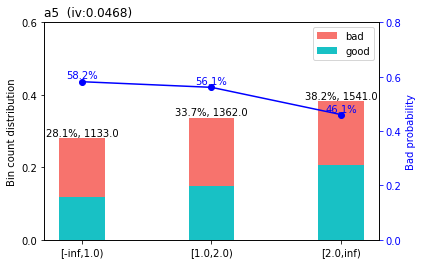

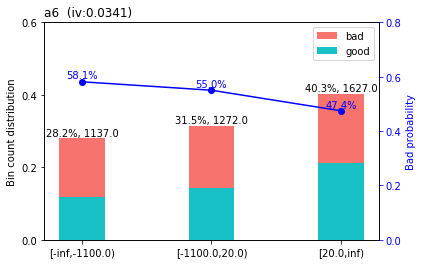

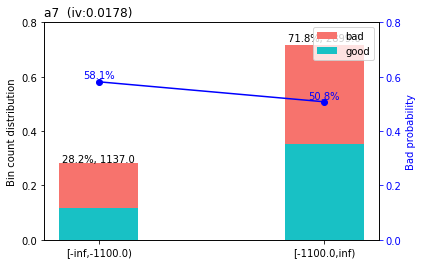

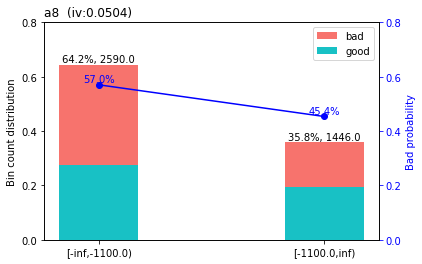

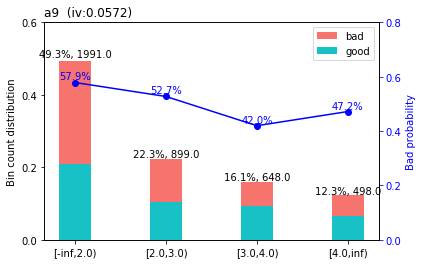

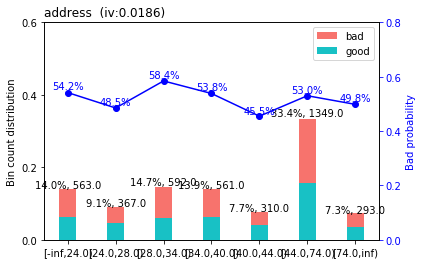

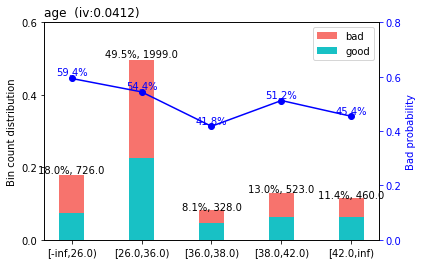

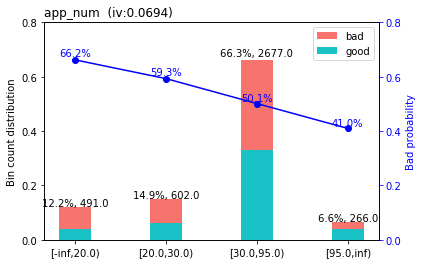

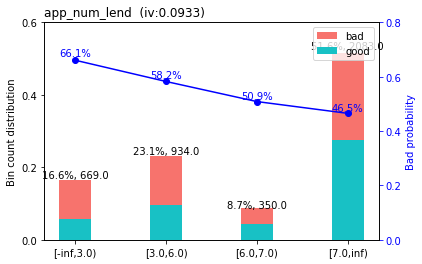

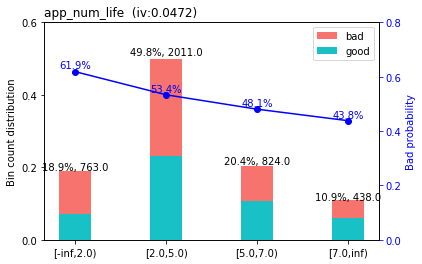

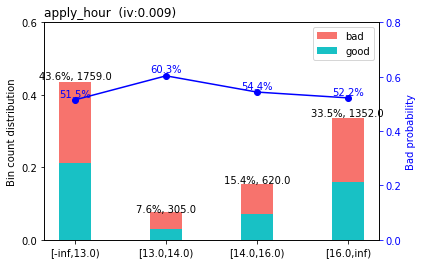

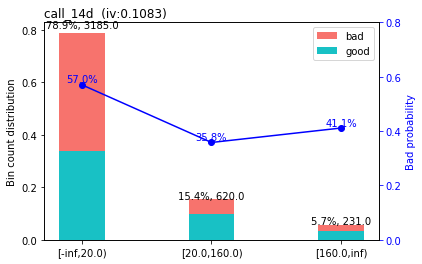

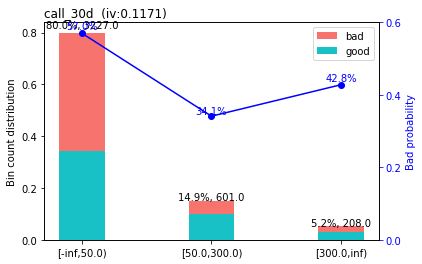

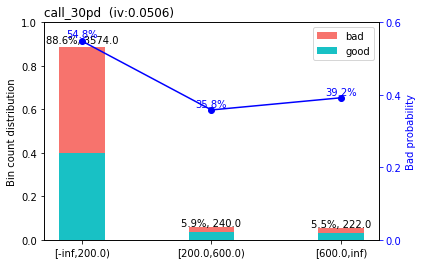

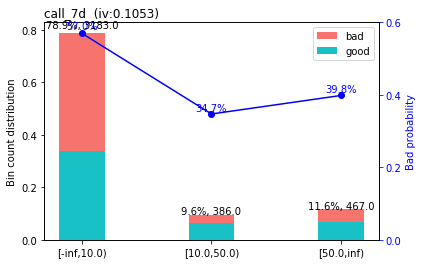

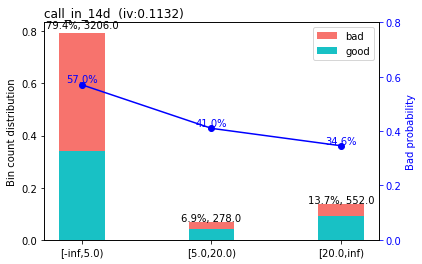

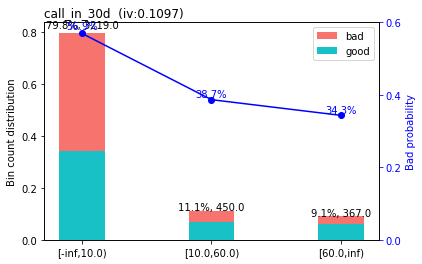

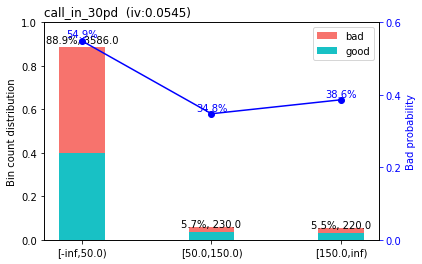

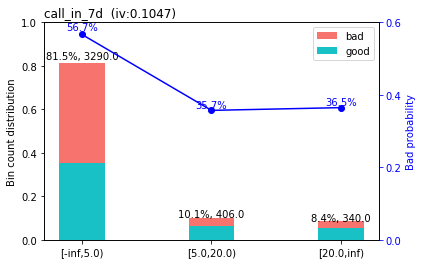

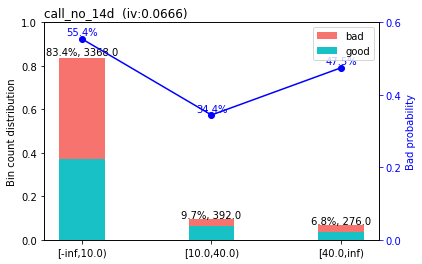

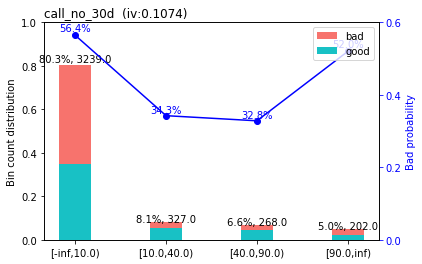

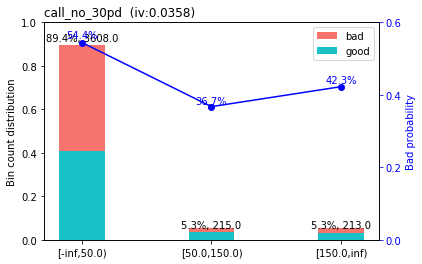

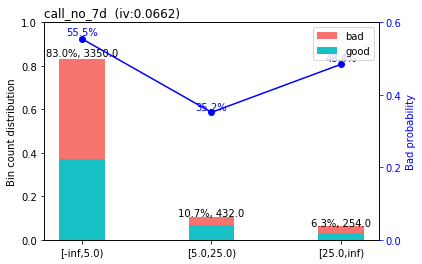

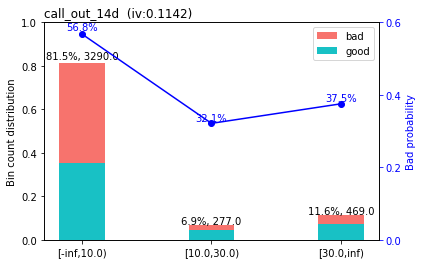

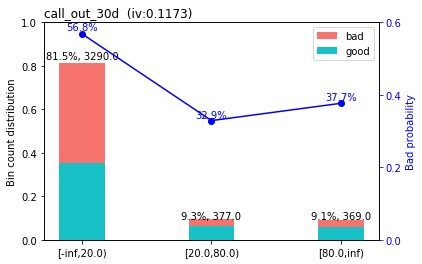

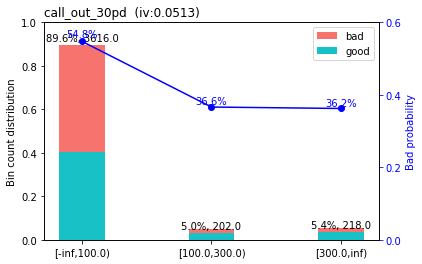

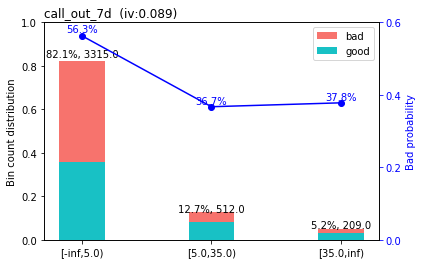

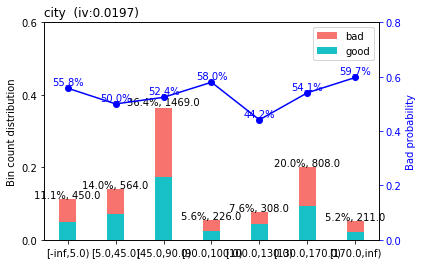

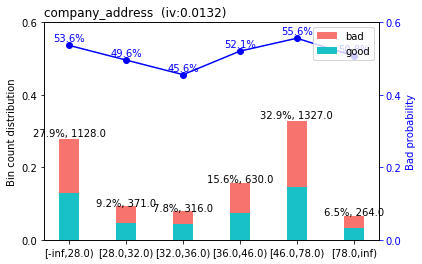

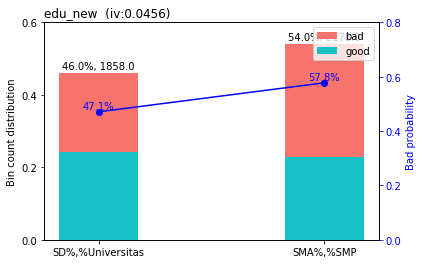

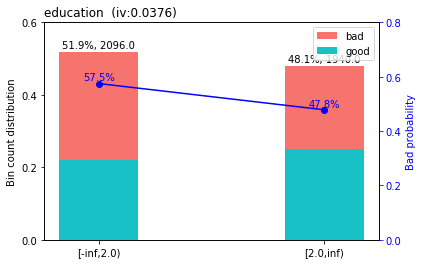

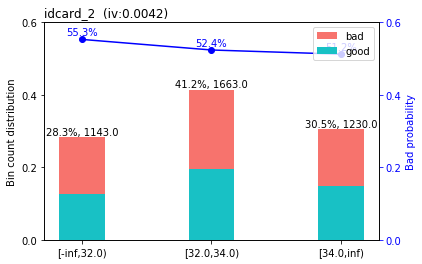

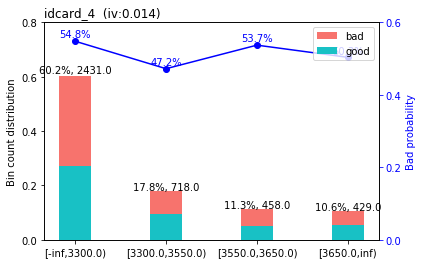

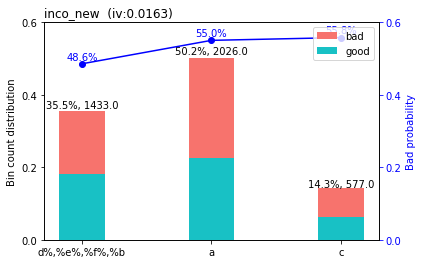

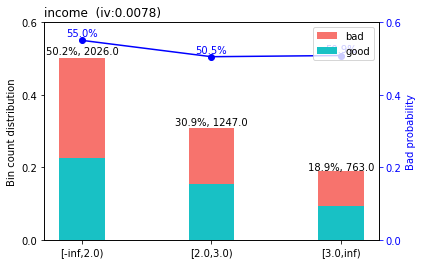

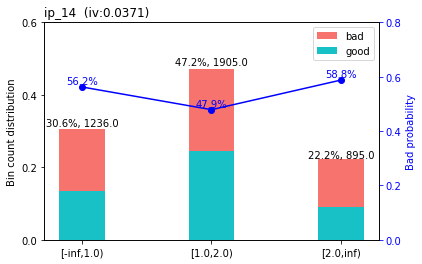

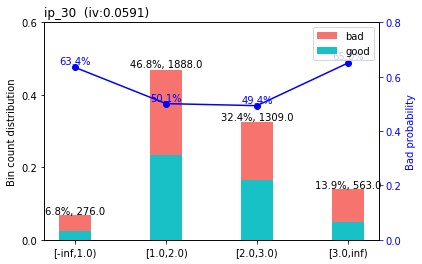

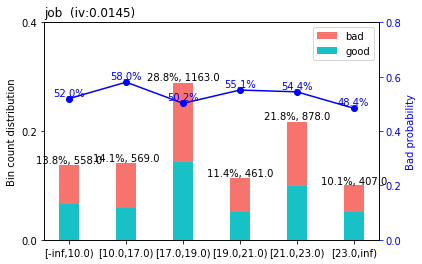

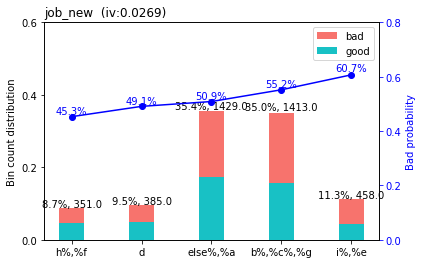

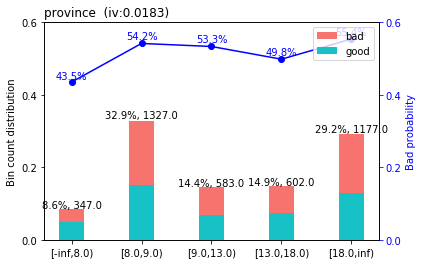

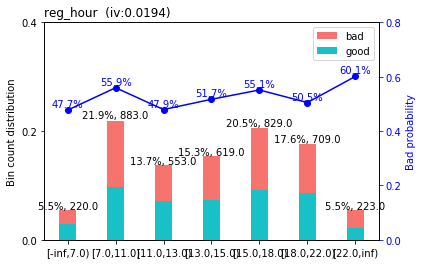

In [471]:
# dt_0d = sc.var_filter(df_0d, y="bad_y")
# bin_0d = sc.woebin(dt_0d, y="bad_y")
# sc.woebin_plot(bin_0d)

In [474]:
#分测试和训练
# train_0d, test_0d = sc.split_df(dt_0d, y = 'bad_y').values()

# train_woe_0d = sc.woebin_ply(train_0d, bin_0d)
# test_woe_0d = sc.woebin_ply(test_0d, bin_0d)
# y_train_0d = train_woe_0d.loc[:,'bad_y']
# X_train_0d = train_woe_0d.drop(['bad_y'],1)
# y_test_0d = test_woe_0d.loc[:,'bad_y']
# X_test_0d = test_woe_0d.drop(['bad_y'],1)

# lr_0d = LogisticRegression(penalty = 'l1', C = 0.5, solver = 'saga')
# lr_0d.fit(X_train_0d, y_train_0d)
# ylr_hat_0d = lr_0d.predict_proba(X_test_0d)[:,1]
# auc_ks(ylr_hat_0d,y_test_0d)

AUC： 0.6718667907180386
KS: 0.24868925131348513


(0.6718667907180386, 0.24868925131348513)

In [242]:
# woe_0d = sc.woebin_ply(dt_s1, bins1)

# Y = woe.loc[:,'bad']
# X = woe.drop(['bad'],1)

# param_grid = {'C': np.arange(0.1,4.9,0.1),'penalty': [ 'l1','l2']}
# clf_grid = GridSearchCV(
#     LogisticRegression(),param_grid,scoring ='roc_auc',cv = 10)
# clf_grid.fit(X, Y)